# Customer Churn Analysis
Goal:EDA, feature engineering, models (Logistic Regression, Random Forest, XGBoost), evaluation

Dataset: `data.csv` 


In [1]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost shap joblib


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib



In [4]:
df = pd.read_csv("data.csv")
print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Data cleaning**


In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

cols_replace_internet = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for c in cols_replace_internet:
    if c in df.columns:
        df[c] = df[c].replace({'No internet service':'No'})

if 'MultipleLines' in df.columns:
    df['MultipleLines'] = df['MultipleLines'].replace({'No phone service':'No'})

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


**Feature engineering**

In [6]:
df['tenure_band'] = pd.cut(df['tenure'], bins=[-1,3,12,24,48,72], labels=['0-3m','4-12m','13-24m','25-48m','49-72m'])
df['contract_bucket'] = df['Contract'].map({'Month-to-month':'Short Term','One year':'Mid Term','Two year':'Long Term'})
df['high_monthly'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)
df[['tenure','tenure_band','Contract','contract_bucket','MonthlyCharges','high_monthly']].head()


,tenure,tenure_band,Contract,contract_bucket,MonthlyCharges,high_monthly
0,1,0-3m,Month-to-month,Short Term,29.85,0
1,34,25-48m,One year,Mid Term,56.95,0
2,2,0-3m,Month-to-month,Short Term,53.85,0
3,45,25-48m,One year,Mid Term,42.30,0
4,2,0-3m,Month-to-month,Short Term,70.70,1


**EDA**

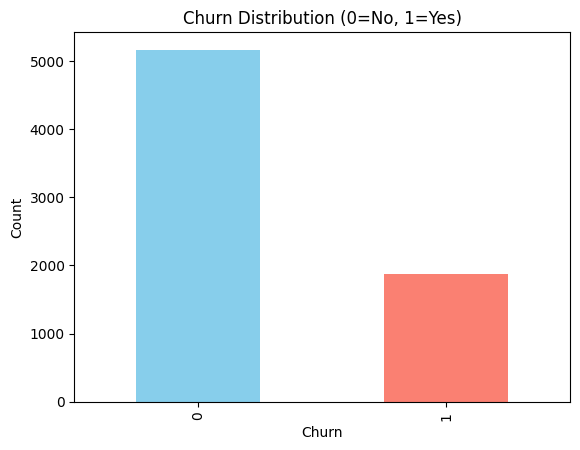

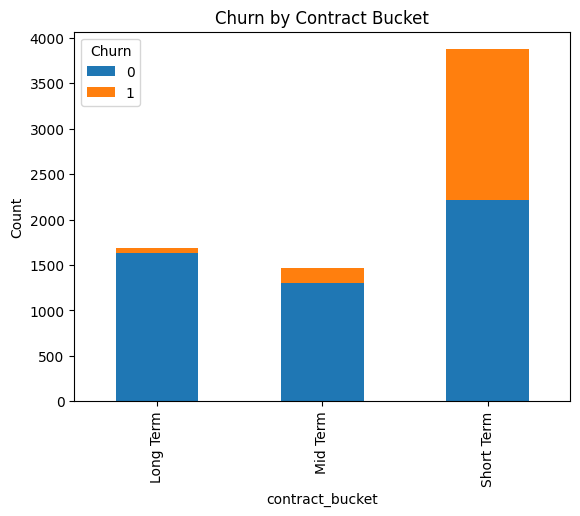

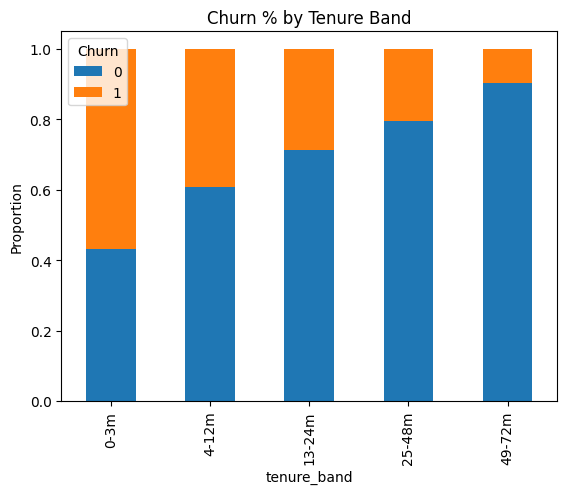

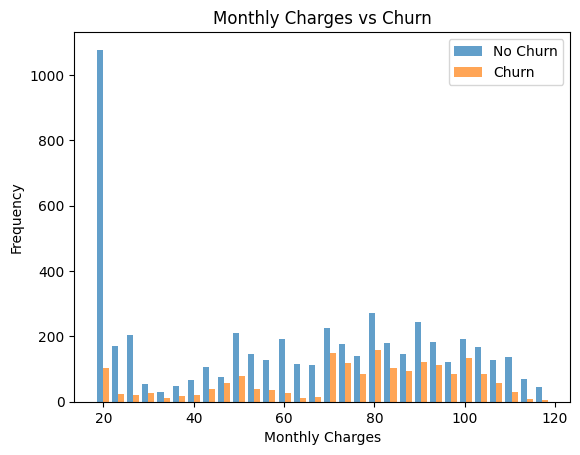

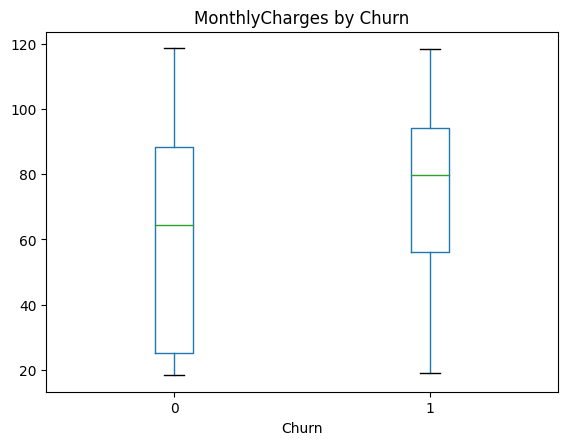

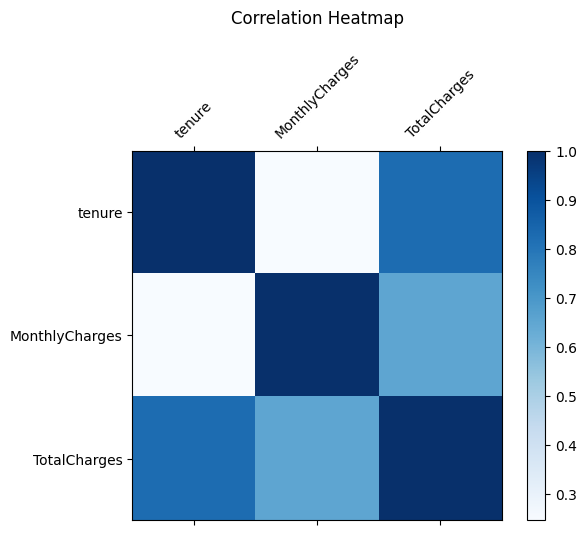

In [7]:
# Churn distribution
df['Churn'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Churn Distribution (0=No, 1=Yes)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# Churn by Contract
ct_contract = pd.crosstab(df['contract_bucket'], df['Churn'])
ct_contract.plot(kind='bar', stacked=True)
plt.title("Churn by Contract Bucket")
plt.ylabel("Count")
plt.show()

# Churn by Tenure Band (percentage)
ct_tenure = pd.crosstab(df['tenure_band'], df['Churn'])
(ct_tenure.div(ct_tenure.sum(axis=1), axis=0)).plot(kind='bar', stacked=True)
plt.title("Churn % by Tenure Band")
plt.ylabel("Proportion")
plt.show()

# MonthlyCharges histogram
plt.hist([df[df['Churn']==0]['MonthlyCharges'], df[df['Churn']==1]['MonthlyCharges']], 
         bins=30, label=['No Churn','Churn'], alpha=0.7)
plt.xlabel("Monthly Charges")
plt.ylabel("Frequency")
plt.legend()
plt.title("Monthly Charges vs Churn")
plt.show()

# Boxplot MonthlyCharges
df.boxplot(column='MonthlyCharges', by='Churn', grid=False)
plt.title("MonthlyCharges by Churn")
plt.suptitle("")
plt.show()

# Correlation heatmap
num_cols = ['tenure','MonthlyCharges','TotalCharges']
corr = df[num_cols].corr()

fig, ax = plt.subplots()
cax = ax.matshow(corr, cmap="Blues")
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar(cax)
plt.title("Correlation Heatmap", pad=20)
plt.show()


**Preprocessing**


In [8]:
X = df.drop(columns=['Churn'])
y = df['Churn']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_features = ['tenure','MonthlyCharges','TotalCharges']
num_features_present = [c for c in num_features if c in X_train.columns]

scaler = StandardScaler()
X_train[num_features_present] = scaler.fit_transform(X_train[num_features_present])
X_test[num_features_present] = scaler.transform(X_test[num_features_present])

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (5625, 30) | Test shape: (1407, 30)


**Matrics and confusion matrix**

In [9]:
def print_metrics(y_true, y_pred, y_prob=None):
    print(classification_report(y_true, y_pred, digits=4))
    if y_prob is not None:
        print("ROC AUC:", roc_auc_score(y_true, y_prob))

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar(cax)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, val, ha='center', va='center', color='red')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



---- LogisticRegression ----
              precision    recall  f1-score   support

           0     0.8417    0.8906    0.8655      1033
           1     0.6401    0.5374    0.5843       374

    accuracy                         0.7967      1407
   macro avg     0.7409    0.7140    0.7249      1407
weighted avg     0.7881    0.7967    0.7907      1407

ROC AUC: 0.8376917342665309


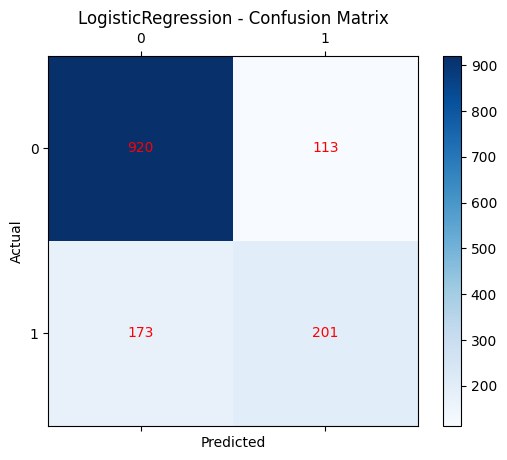


---- RandomForest ----
              precision    recall  f1-score   support

           0     0.8341    0.8858    0.8592      1033
           1     0.6194    0.5134    0.5614       374

    accuracy                         0.7868      1407
   macro avg     0.7267    0.6996    0.7103      1407
weighted avg     0.7770    0.7868    0.7800      1407

ROC AUC: 0.8215040042242366


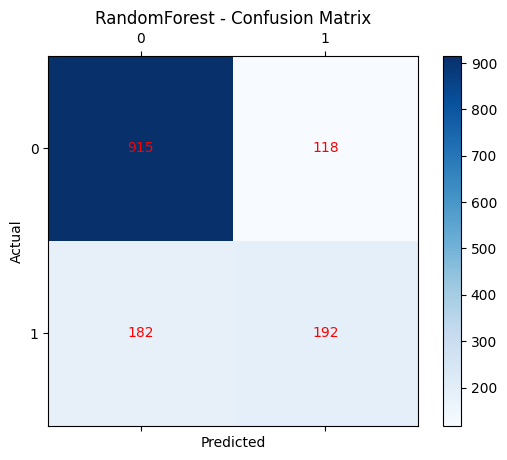

In [10]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n---- {name} ----")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    print_metrics(y_test, y_pred, y_prob)
    plot_confusion(y_test, y_pred, title=f"{name} - Confusion Matrix")
    results[name] = {'model': model, 'y_pred': y_pred, 'y_prob': y_prob}
    joblib.dump(model, f"{name}.joblib")


**ROC CURVE**

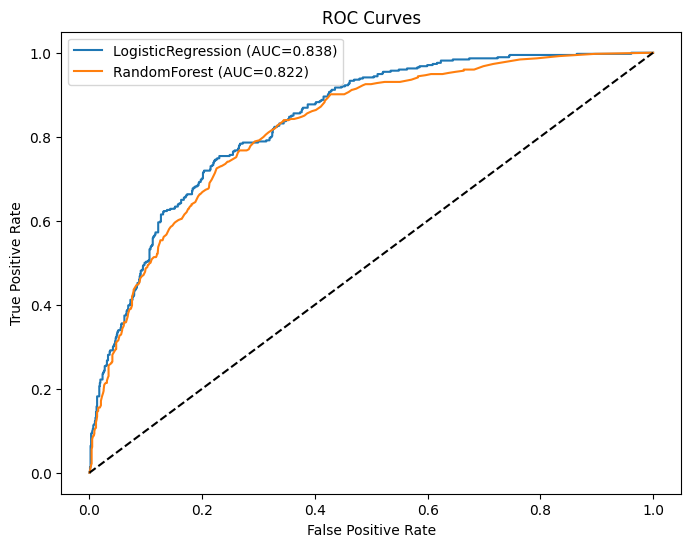

In [11]:
plt.figure(figsize=(8,6))
for name, info in results.items():
    fpr, tpr, _ = roc_curve(y_test, info['y_prob'])
    auc = roc_auc_score(y_test, info['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


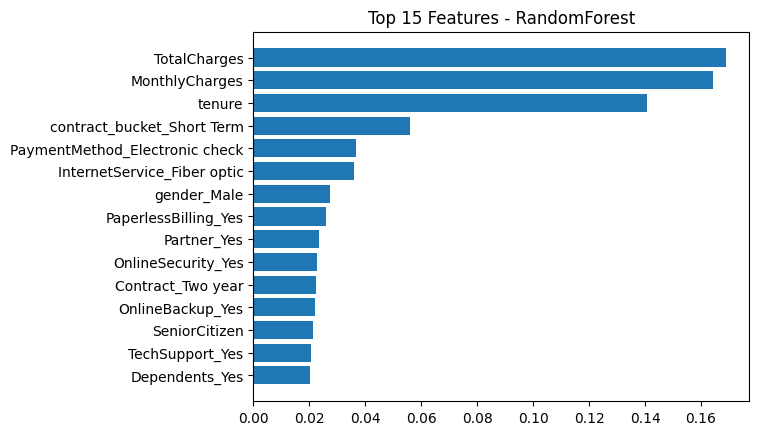

In [12]:
rf_model = results['RandomForest']['model']
fi = rf_model.feature_importances_
top_idx = np.argsort(fi)[::-1][:15]

plt.barh(range(len(top_idx)), fi[top_idx][::-1], align='center')
plt.yticks(range(len(top_idx)), np.array(X_train.columns)[top_idx][::-1])
plt.title("Top 15 Features - RandomForest")
plt.show()
